# Clustering 
### Clientes basado en sus características de compra
Incluye insights de cada cluster basados en su comportamiento (E Commerce Dataset) 

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#### Cargar datos y preprocesamiento

In [2]:
# Cargar los datos
df = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')

# Preprocesamiento
features_num = ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
features_cat = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']

# Eliminar los valores NaN
df = df.dropna()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(), features_cat)])

df_preprocessed = preprocessor.fit_transform(df)

### Determinar el número óptimo de clusters
Método del codo

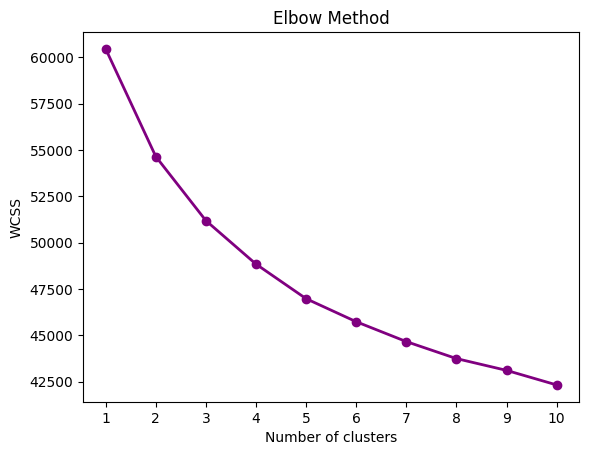

In [3]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_preprocessed)
    wcss.append(kmeans.inertia_)

# Se crea un gráfico de la suma de las distancias al cuadrado dentro del cluster en función del número de clusters
plt.plot(range(1, 11), wcss, linewidth=2, color='purple', marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.xticks(range(1, 11))

plt.show()

### Corroborar el número óptimo de clusters
Método de la silueta

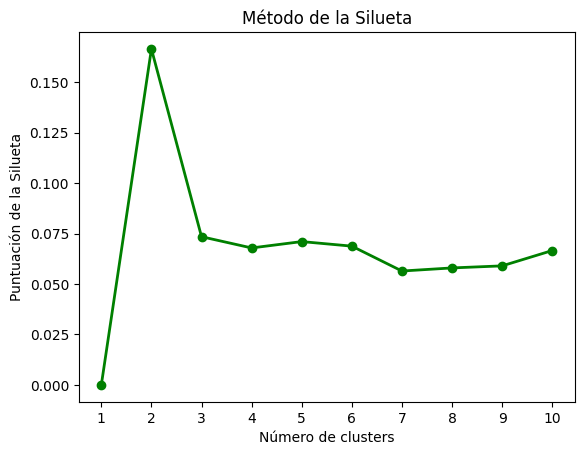

In [4]:
sil = [0]  # Valor predeterminado para un solo cluster
kmax = 10

# Calculamos la puntuación de la silueta para 2 a 10 clusters
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df_preprocessed)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_preprocessed, labels, metric = 'euclidean'))

# Creamos un gráfico de la puntuación de la silueta en función del número de clusters
plt.plot(range(1, kmax+1), sil, linewidth=2, color='green', marker='o')
plt.title('Método de la Silueta')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de la Silueta')

plt.xticks(range(1, 11))

plt.show()

### Aplicar el algoritmo de K-means

In [5]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(df_preprocessed)

### Análisis los clusters generados

In [6]:
df['Cluster'] = clusters

### Visulización de clusters generados

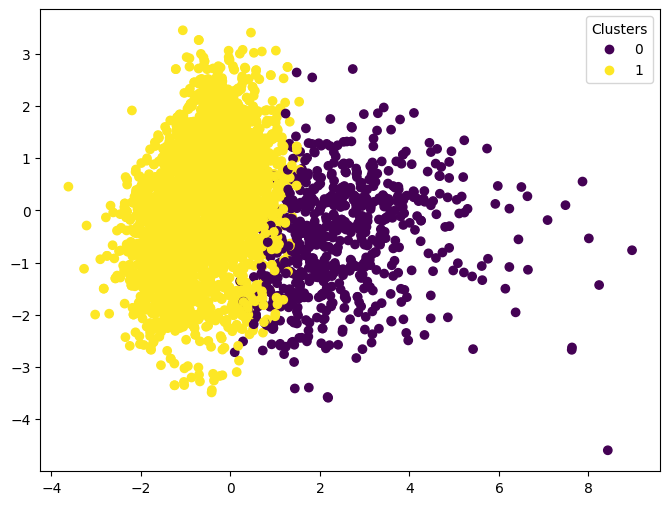

In [7]:
# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_preprocessed)

# Crear un DataFrame con los resultados de PCA
df_pca = pd.DataFrame(data=df_pca, columns=['Principal Component 1', 'Principal Component 2'])

# Añadir la columna de clusters al DataFrame de PCA
df_pca['Cluster'] = clusters

# Crear la gráfica de dispersión
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_pca['Principal Component 1'], df_pca['Principal Component 2'], c=df_pca['Cluster'], cmap='viridis')

# Añadir la leyenda
plt.legend(*scatter.legend_elements(), title="Clusters")

# Mostrar la gráfica
plt.show()

### Calcular la media de las características numéricas y la moda de las características categóricas para cada cluster

In [8]:
df.groupby('Cluster').agg({**{feature: 'mean' for feature in features_num}, **{feature: lambda x: x.value_counts().index[0] for feature in features_cat}})

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
Cluster,,,,,,,,,,,,,,,,,,
0,10.529326,1.790323,15.708211,3.000000,3.725806,3.057185,3.618768,0.280059,15.822581,4.145161,7.189150,8.340176,176.539179,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
1,8.390362,1.689521,15.751617,2.977038,3.760349,3.056274,4.348318,0.282665,15.706662,1.184670,1.862872,3.684994,161.494945,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married


### 